In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from tiingo import TiingoClient
pd.core.common.is_list_like = pd.api.types.is_list_like
import ffn
import statsmodels.api as sm
import scipy.stats as st
import bt
import cvxopt as opt
from cvxopt import blas, solvers
import seaborn as sns
from pypfopt import risk_models
import scipy
import datetime as dt

In [2]:
config = {}
# To reuse the same HTTP Session across API calls (and have better performance), include a session key.
config['session'] = True
config['api_key'] = "9606b7b7c092fa68b5726d3feee8d44f40354fe3"
# Initialize
client = TiingoClient(config)

# 2 - Portfolio Analysis: A Primer

In [3]:
# 2.1.2
start_date='2000-01-01'
end_date='2018-12-01'
tickers = ['SPY','IEF']


start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)
prices = pd.DataFrame()

for ticker in tickers:
#     prices[ticker] = get_historical_data(ticker, start=start_date, end=end_date, output_format='pandas').loc[:,'close']
    prices[ticker] = client.get_dataframe(ticker, startDate=start_date, endDate=end_date).loc[:,'adjClose']
prices = prices.dropna()
print(prices.head())
rets = prices.pct_change()
rets = rets.dropna()
print(rets.head())
perf = prices.calc_stats()

                                 SPY        IEF
date                                           
2002-07-26 00:00:00+00:00  61.757579  50.465664
2002-07-29 00:00:00+00:00  64.766096  49.874388
2002-07-30 00:00:00+00:00  65.610213  49.843910
2002-07-31 00:00:00+00:00  65.768935  50.301082
2002-08-01 00:00:00+00:00  64.051844  50.508333
                                SPY       IEF
date                                         
2002-07-29 00:00:00+00:00  0.048715 -0.011716
2002-07-30 00:00:00+00:00  0.013033 -0.000611
2002-07-31 00:00:00+00:00  0.002419  0.009172
2002-08-01 00:00:00+00:00 -0.026108  0.004120
2002-08-02 00:00:00+00:00 -0.022415  0.007724


C:\Users\Beau\Anaconda3\lib\site-packages\ffn\core.py:2054: RuntimeWarning: invalid value encountered in minimum
  negative_returns = np.minimum(returns, 0.)


C:\Users\Beau\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


[Text(0,0.5,'Return'), Text(0.5,0,'Date'), Text(0.5,1,'Daily S&P 500 Returns')]

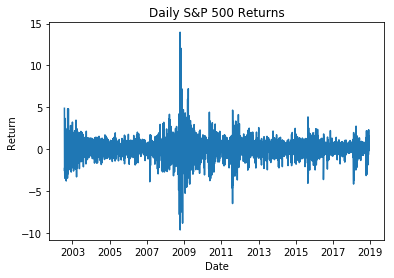

In [4]:
# 2.1.3
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(rets.SPY* 100)
ax.set(title='Daily S&P 500 Returns', xlabel='Date', ylabel='Return')

[Text(0,0.5,'Price'), Text(0.5,0,'Date'), Text(0.5,1,'S&P 500 Index')]

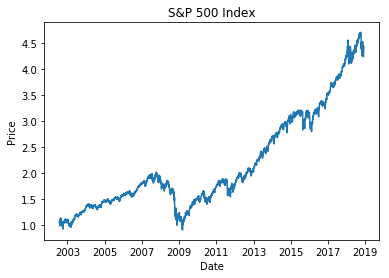

In [5]:
# 2.1.4
# 2.1.4
sp500_index = np.cumprod(1 + rets.SPY)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(sp500_index)
ax.set(title='S&P 500 Index', xlabel='Date', ylabel='Price')

In [6]:
# 2.1.5
sp500_index = 100*np.cumprod((1+rets.SPY))

In [10]:
# 2.1.6 
sp500_ret = sp500_index.pct_change().dropna()

In [11]:
# 2.1.7
data_test = pd.concat([sp500_ret, rets.SPY],axis=1)

In [12]:
# 2.1.8
sp500_12mo_ret = prices.SPY.pct_change(252).dropna()

[Text(0,0.5,'% Return'),
 Text(0.5,0,'Date'),
 Text(0.5,1,'S&P 500 vs 10-Year Treasury')]

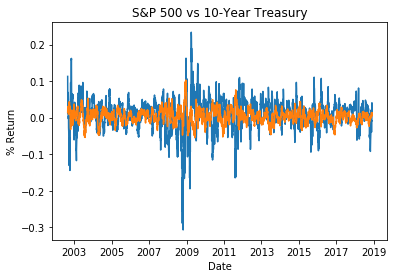

In [13]:
# 2.2.1

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(prices.pct_change(21))
ax.set(title='S&P 500 vs 10-Year Treasury', xlabel='Date', ylabel='% Return')


In [14]:
# 2.3.1
vol = rets.std()
print(vol)
# 2.3.2
vol_annualized = vol * np.sqrt(252)
print(vol_annualized)

# 2.3.3
vol_roll = rets.rolling(window=252).std().dropna()
print(vol_roll.head())
 
# 2.3.4
corr_matrix = rets.corr()
corr_roll = rets.SPY.rolling(window=252).corr(other=rets.IEF).dropna()
print(corr_matrix)
print(corr_roll.head())

SPY    0.011637
IEF    0.004161
dtype: float64
SPY    0.184734
IEF    0.066051
dtype: float64
                                SPY       IEF
date                                         
2003-07-28 00:00:00+00:00  0.015494  0.004737
2003-07-29 00:00:00+00:00  0.015199  0.004719
2003-07-30 00:00:00+00:00  0.015179  0.004744
2003-07-31 00:00:00+00:00  0.015179  0.004731
2003-08-01 00:00:00+00:00  0.015098  0.004725
          SPY       IEF
SPY  1.000000 -0.397464
IEF -0.397464  1.000000
date
2003-07-28 00:00:00+00:00   -0.544700
2003-07-29 00:00:00+00:00   -0.522621
2003-07-30 00:00:00+00:00   -0.521183
2003-07-31 00:00:00+00:00   -0.524296
2003-08-01 00:00:00+00:00   -0.520978
dtype: float64


In [15]:
# 2.4.1
round(rets.SPY.std(), 5)
 
# 2.4.2
# round(returns.geltner(rets.SPY).std(),5)
# TODO

# # 2.4.3
round(rets.SPY.std()*np.sqrt(252), 5)
 
# # 2.4.4
def SharpeRatio(returns, rf=0.01/252, N=252):
    """Calculate annualized sharpe ratio:
    :dataframe returns: a dataframe, asset returns
    :param rf: a float, the risk free rate, default=1%
    :param N: an int, the number of trading periods, default=252
    
    RETURNS:
    :Sharpe Ratio: float"""
    return np.sqrt(N) * (returns.mean() - rf) / returns.std()
round(SharpeRatio(rets.SPY), 3)

0.532

In [16]:
# 2.5.1
round(perf['SPY'].stats['yearly_sortino'], 3)

1.172

In [17]:
# 2.6.1 
# CAPM.beta(Ra=managers$EDHEC, Rb=managers$SP500)
 
# 2.6.2
model =sm.OLS(rets.IEF, rets.SPY)
results = model.fit()
beta=float(results.params)
print(round(beta,3))

-0.141


[Text(0,0.5,'% Return'),
 Text(0.5,0,'Date'),
 Text(0.5,1,'Sorted S&P 500 Returns')]

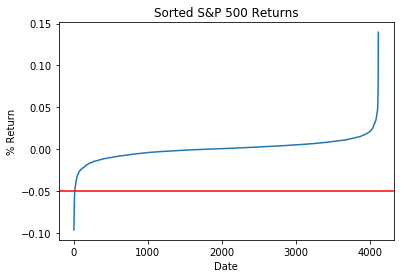

In [18]:
# 2.7.1
scipy.stats.norm.ppf(0.05, loc=0.07, scale=0.1)
 
# 2.7.2
scipy.stats.norm.cdf(-0.09448536,loc=0.07, scale=0.1)
 
# 2.7.3
scipy.stats.norm.ppf([0.05,0.01,0.001], loc=0.07, scale=0.1) 
 
# 2.7.4
np.random.seed(87655678)
ret_sim = np.random.normal(loc=0.07, scale=0.1, size=10000)
ret_sim_var = np.quantile(ret_sim, [0.05, 0.01, 0.001])

# 2.7.5
np.quantile(rets.SPY.pct_change(252).dropna(), 0.05)
 
# # 2.7.6
sp500_sort = rets.SPY.sort_values()
sp500_sort_var95 = np.quantile(sp500_sort,0.05)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(0,len(sp500_sort)),sp500_sort)
ax.axhline(y=-0.05,color='red')
ax.set(title='Sorted S&P 500 Returns', xlabel='Date', ylabel='% Return')

In [19]:
# 2.8.1
scipy.stats.norm.cdf(0,loc=rets.SPY.mean(), scale=rets.SPY.std())
 
# 2.8.2
rets.SPY.mean()
 
# 2.8.3
1-scipy.stats.norm.cdf(0, loc=rets.SPY.mean(), scale=rets.SPY.std())
 

0.5147251203058092

[Text(0,0.5,'Drawdown %'),
 Text(0.5,0,'Date'),
 Text(0.5,1,'Sorted S&P 500 Drawdowns')]

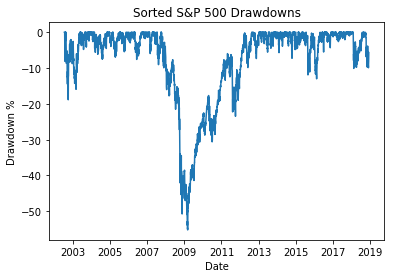

In [20]:
# 2.9.1
drawdown_series = ffn.to_drawdown_series(prices.SPY)
drawdowns = ffn.drawdown_details(drawdown_series)
drawdowns.sort_values(by='Length', ascending=False)[0:3]

# 2.9.2
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(drawdown_series * 100)
ax.set(title='Sorted S&P 500 Drawdowns', xlabel='Date', ylabel='Drawdown %')
 

# 3 - Rebalancing and Backtesting

Rebalance
0% [############################# ] 100% | ETA: 00:00:00No Rebalance
0% [############################# ] 100% | ETA: 00:00:00

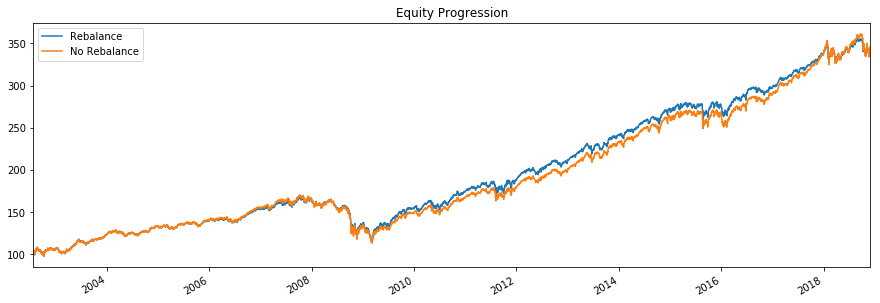

In [21]:
# 3.1.1
weights = pd.Series([0.6,0.4],index = prices.columns)
weighSpecifiedAlgo = bt.algos.WeighSpecified(**weights)
s = bt.Strategy('Rebalance', [bt.algos.RunMonthly(),
                       bt.algos.SelectAll(),
                       weighSpecifiedAlgo,
                       bt.algos.Rebalance()])

test = bt.Backtest(s, prices)
s2 = bt.Strategy('No Rebalance', [bt.algos.RunOnce(),
                       bt.algos.SelectAll(),
                       weighSpecifiedAlgo,
                       bt.algos.Rebalance()])

test2 = bt.Backtest(s2, prices)
res= bt.run(test, test2)
res.plot()


In [22]:
# 3.1.2
res.display()

Stat                 Rebalance    No Rebalance
-------------------  -----------  --------------
Start                2002-07-25   2002-07-25
End                  2018-11-30   2018-11-30
Risk-free rate       0.00%        0.00%

Total Return         245.06%      246.38%
Daily Sharpe         0.80         0.77
Daily Sortino        1.29         1.23
CAGR                 7.87%        7.89%
Max Drawdown         -32.18%      -33.20%
Calmar Ratio         0.24         0.24

MTD                  1.63%        1.73%
3m                   -2.81%       -3.62%
6m                   1.48%        1.66%
YTD                  2.27%        3.09%
1Y                   3.08%        4.08%
3Y (ann.)            7.36%        8.79%
5Y (ann.)            7.59%        8.52%
10Y (ann.)           10.65%       10.81%
Since Incep. (ann.)  7.87%        7.89%

Daily Sharpe         0.80         0.77
Daily Sortino        1.29         1.23
Daily Mean (ann.)    8.09%        8.16%
Daily Vol (ann.)     10.08%       10.59%
Daily Ske

Moving Average
0% [############################# ] 100% | ETA: 00:00:00

C:\Users\Beau\Anaconda3\lib\site-packages\ffn\core.py:2054: RuntimeWarning: invalid value encountered in minimum
  negative_returns = np.minimum(returns, 0.)


Stat                 Rebalance    No Rebalance    Moving Average
-------------------  -----------  --------------  ----------------
Start                2002-07-25   2002-07-25      2002-07-25
End                  2018-11-30   2018-11-30      2018-11-30
Risk-free rate       0.00%        0.00%           0.00%

Total Return         245.06%      246.38%         226.49%
Daily Sharpe         0.80         0.77            0.92
Daily Sortino        1.29         1.23            1.45
CAGR                 7.87%        7.89%           7.51%
Max Drawdown         -32.18%      -33.20%         -10.62%
Calmar Ratio         0.24         0.24            0.71

MTD                  1.63%        1.73%           1.85%
3m                   -2.81%       -3.62%          -4.62%
6m                   1.48%        1.66%           2.03%
YTD                  2.27%        3.09%           4.11%
1Y                   3.08%        4.08%           4.83%
3Y (ann.)            7.36%        8.79%           8.98%
5Y (ann.)     

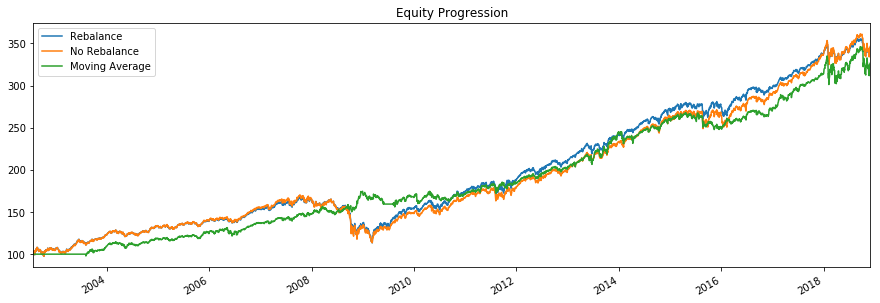

In [23]:
# 3.2.1
sma  = prices.rolling(window=252,center=False).mean().shift(1) # create trend signal
trend = sma.copy()
trend[prices > sma] = True
trend[prices <= sma] = False
trend[sma.isnull()] = False

# 3.2.2-3.27
s3 = bt.Strategy('Moving Average', [bt.algos.RunMonthly(),
                       bt.algos.SelectWhere(trend),
                       bt.algos.WeighEqually(),
                       bt.algos.Rebalance()])

test3 = bt.Backtest(s3, prices)
res= bt.run(test, test2, test3)
res.plot()
res.display()


# 4 - Estimating "Optimal" Portfolios

In [24]:
# 4.1.1
start_date='2000-01-01'
end_date='2018-06-01'
tickers = ['SPY','IEF','EFA','DBC','TIP']

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)
prices = pd.DataFrame()

for ticker in tickers:
    prices[ticker] = client.get_dataframe(ticker, startDate=start_date, endDate=end_date).loc[:,'adjClose']
prices = prices.dropna()
returns = prices.pct_change()
returns = returns.dropna()

In [25]:
# 4.1.2
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns


mu = expected_returns.mean_historical_return(prices)
S = risk_models.sample_cov(prices)

# Optimise for maximal Sharpe ratio
ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1))
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

{'SPY': 0.64265, 'IEF': 0.86934, 'EFA': -0.30887, 'DBC': -0.06188, 'TIP': -0.14124}
Expected annual return: 8.1%
Annual volatility: 6.7%
Sharpe Ratio: 0.88


(0.08057519724223751, 0.06658521272283188, 0.8839808960300696)

In [26]:
# 4.1.3
mu = expected_returns.mean_historical_return(prices)
S = risk_models.sample_cov(prices)

# Optimise for maximal Sharpe ratio
ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

{'SPY': 0.26247, 'IEF': 0.73753, 'EFA': 0.0, 'DBC': 0.0, 'TIP': 0.0}
Expected annual return: 6.1%
Annual volatility: 5.4%
Sharpe Ratio: 0.75


(0.06112425454301154, 0.05394687823403409, 0.7500533363689664)

In [28]:
# 4.1.4
mu = expected_returns.mean_historical_return(prices)
S = risk_models.sample_cov(prices)

# Optimise for maximal Sharpe ratio
ef = EfficientFrontier(mu, S, weight_bounds=(0.1, 1))
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

{'SPY': 0.13876, 'IEF': 0.56124, 'EFA': 0.1, 'DBC': 0.1, 'TIP': 0.1}
Expected annual return: 5.1%
Annual volatility: 6.0%
Sharpe Ratio: 0.51


(0.05056393224877336, 0.059603408621674715, 0.5055034627859594)

# 5 Factor Analysis

In [27]:
# 5.1.1
import pandas_datareader as pdr
from pandas_datareader.famafrench import get_available_datasets
french = pdr.DataReader('F-F_Research_Data_Factors_daily', 'famafrench',start = "2000-01-01")[0]
french.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
2000-01-03,-0.71,0.39,-0.84,0.021
2000-01-04,-4.06,-0.05,2.21,0.021
2000-01-05,-0.09,0.17,0.13,0.021
2000-01-06,-0.73,-0.68,1.37,0.021
2000-01-07,3.21,-0.58,-1.24,0.021


In [29]:
# 5.1.2
start_date='2000-01-01'
end_date='2018-06-01'
tickers = ['SPY','BIL']

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)
prices = pd.DataFrame()

for ticker in tickers:
    prices[ticker] = client.get_dataframe(ticker, startDate=start_date, endDate=end_date).loc[:,'adjClose']
prices = prices.dropna()
returns = prices.pct_change()
returns = returns.dropna() * 100
sp500_premium = returns.SPY - returns.BIL
sp500_premium = pd.DataFrame(data=sp500_premium)
sp500_premium.columns = ['sp500_premium']
sp500_premium.index = sp500_premium.index.tz_localize(None)

In [30]:
# 5.1.3
french_factors_sp500 = french.join(sp500_premium, how='left')
# french_factors_sp500.sp500 = french_factors_sp500.sp500 - french_factors_sp500.RF

In [31]:
# 5.1.4
import statsmodels.api as sm
results = sm.OLS(french_factors_sp500.sp500_premium,french_factors_sp500.iloc[:,1:-1]).fit()

In [32]:
# 5.1.5
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          sp500_premium   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 23 Feb 2019   Prob (F-statistic):                nan
Time:                        13:20:37   Log-Likelihood:                    nan
No. Observations:                4779   AIC:                               nan
Df Residuals:                    4776   BIC:                               nan
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
SMB               nan        nan        nan        n

C:\Users\Beau\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Beau\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Beau\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
C:\Users\Beau\Anaconda3\lib\site-packages\scipy\stats\stats.py:1408: RuntimeWarning: invalid value encountered in less
  term2 = np.where(denom < 0, term1, np.power((1-2.0/A)/denom, 1/3.0))


[Text(0,0.5,'estimated premia'),
 Text(0.5,0,'historical premia'),
 Text(0.5,1,'Fama-French 3-factor Model for S&P 500')]

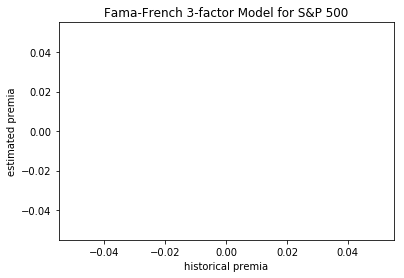

In [33]:
# 5.1.6
estimates = results.get_prediction(french_factors_sp500.iloc[:,1:-1]).summary_frame()
estimates= estimates.loc[:,'mean']
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(french_factors_sp500.sp500_premium, estimates, marker='o', facecolors='none', edgecolors='b')
ax.set(title='Fama-French 3-factor Model for S&P 500', xlabel='historical premia', ylabel='estimated premia')

In [36]:
# 5.2.1 
managers = pd.read_csv("managers.csv", index_col=0)
returns = managers.dropna().iloc[:,0:6]

from sklearn.decomposition import FactorAnalysis, PCA
from sklearn import preprocessing

fa = FactorAnalysis(n_components=1, tol=1e-6, max_iter=10000)
returns_normal = -1*preprocessing.scale(returns)
fa.fit(returns_normal)
loadings = pd.DataFrame(fa.components_[0], index=managers.columns[0:6],columns=['Loadings'])
print(loadings)
print("Sum of Squared Loadings: ", np.sum(fa.components_[0] **2)) # Note this is for a single factor. Will need to be more Numpy-ish if using multiple factors
print("Explained Variance: ", np.sum(fa.components_[0] **2)/(np.sum(fa.components_[0]**2) + np.sum(fa.noise_variance_)))

      Loadings
HAM1  0.898552
HAM2  0.478287
HAM3  0.744631
HAM4  0.750427
HAM5  0.523752
HAM6  0.658798
Sum of Squared Loadings:  2.8620998526407
Explained Variance:  0.4770170697838761


[Text(0,0.5,'Variance'),
 Text(0.5,0,'Principal Component Portfolios'),
 Text(0.5,1,'PCA Portfolio Variance')]

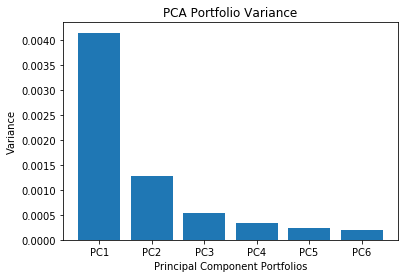

In [37]:
# 5.2.2
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(returns)
eigenvalues = pca.explained_variance_
pca_variances = pd.DataFrame(data=eigenvalues, columns=['Variance'], index=["PC" +str(i) for i in range(1,7)]).sort_values(by='Variance',ascending=False)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(x=pca_variances.index, height=pca_variances.Variance)
ax.set(title='PCA Portfolio Variance', xlabel='Principal Component Portfolios', ylabel='Variance')

In [38]:
# 5.2.3
standard_deviation = np.sqrt(pca.explained_variance_)
prop_variation = pca.explained_variance_ratio_
cumulative_proporiton = np.cumsum(pca.explained_variance_ratio_)
pca_summary = pd.DataFrame(data={'Standard Deviation':standard_deviation, 'Proportion of Variance':prop_variation, 'Cumulative Proportion':cumulative_proporiton},
                           index=["PC" +str(i) for i in range(1,7)])
pca_summary.transpose()

,PC1,PC2,PC3,PC4,PC5,PC6
Standard Deviation,0.064362,0.035737,0.023153,0.018151,0.015202,0.013698
Proportion of Variance,0.617924,0.190510,0.079961,0.049143,0.034473,0.027989
Cumulative Proportion,0.617924,0.808434,0.888395,0.937538,0.972011,1.000000


In [39]:
# 5.2.4
eigenfolios = np.empty(shape=6)
for i in range(len(pca.components_)):
    denom = sum(pca.components_[i])
    eigenfolio = pca.components_[i]/denom
    eigenfolios = np.vstack((eigenfolios, eigenfolio))
eigenfolios=eigenfolios[1:]
eigenfolios = pd.DataFrame(data=eigenfolios, index=["PC" +str(i) for i in range(1,7)], columns=managers.columns[0:6])
eigenfolios.transpose()

,PC1,PC2,PC3,PC4,PC5,PC6
HAM1,0.173949,0.138947,0.225769,-2.716407,-0.784998,19.182141
HAM2,0.065394,0.133713,0.474893,2.626288,5.208565,4.407197
HAM3,0.120102,0.159690,0.506277,-3.122162,0.784367,-15.455732
HAM4,0.366948,-0.675880,-0.369964,0.620198,0.780374,-3.343971
HAM5,0.157603,1.242005,-0.343429,0.756601,-0.143165,-2.451316
HAM6,0.116004,0.001524,0.506455,2.835482,-4.845142,-1.338319


In [40]:
# 5.2.5
eigenfolios.transpose().sum()

PC1    1.0
PC2    1.0
PC3    1.0
PC4    1.0
PC5    1.0
PC6    1.0
dtype: float64

In [41]:
# 5.2.6
start_date='2000-01-01'
end_date='2018-06-01'
tickers = ['SPY','AGG','EFA','EEM','USO']

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)
prices = pd.DataFrame()

for ticker in tickers:
    prices[ticker] = client.get_dataframe(ticker, startDate=start_date, endDate=end_date).loc[:,'adjClose']
prices = prices.dropna()

In [42]:
# 5.2.7
returns = prices.pct_change().dropna()
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(returns)
pca.components_
pd.DataFrame(data=pca.components_, index=["PC" +str(i) for i in range(1,6)], columns=tickers).transpose()

,PC1,PC2,PC3,PC4,PC5
SPY,0.363509,0.238962,-0.459269,0.756645,-0.165285
AGG,-0.011427,0.002867,-0.013760,-0.216973,-0.976010
EFA,0.452224,0.267963,-0.569017,-0.616560,0.140580
EEM,0.620011,0.387578,0.681980,-0.009308,-0.013666
USO,0.528025,-0.849039,0.002424,0.013386,-0.011686


In [43]:
# 5.2.8
eigenfolios = np.empty(shape=5)
for i in range(len(pca.components_)):
    denom = sum(pca.components_[i])
    eigenfolio = pca.components_[i]/denom
    eigenfolios = np.vstack((eigenfolios, eigenfolio))
eigenfolios=eigenfolios[1:]
eigenfolios = pd.DataFrame(data=eigenfolios, index=["PC" +str(i) for i in range(1,6)], columns=tickers)
eigenfolios.transpose().iloc[:,0]

SPY    0.186191
AGG   -0.005853
EFA    0.231632
EEM    0.317573
USO    0.270457
Name: PC1, dtype: float64

# 6 - Monte Carlo Simulations

In [44]:
# 6.1.1
import random

managers = pd.read_csv("managers.csv", index_col=0)
ret_sp500 = managers['SP500 TR']
ret_sp500_sim_1 = ret_sp500.sample(n=len(ret_sp500),random_state=994, replace=True)

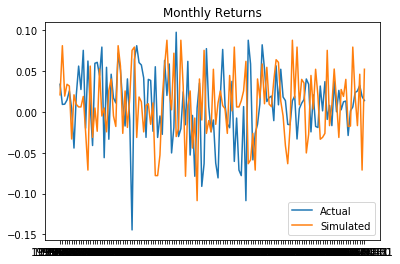

In [45]:
# 6.1.2
import matplotlib.dates as mdates
ret_sp500_sim_1.index= ret_sp500.index
ret_all = pd.concat([ret_sp500, ret_sp500_sim_1], axis=1)
ret_all.columns = ['Actual', 'Simulated']

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(ret_all)
ax.set(title='Monthly Returns')
ax.legend(ret_all.columns)

# FIX DATETIME AXIS

In [46]:
# 6.1.3
ret_sp500_sim_2 = ret_sp500.sample(n=1000, random_state=645, replace=True)

In [47]:
# 6.1.4
managers = pd.read_csv("managers.csv", index_col=0)
ret_a = managers.iloc[:,7:10]
ret_a_sim = ret_a.sample(n=len(ret_a), random_state = 44,replace=True)

In [48]:
# 6.1.5
def fun_a(returns, sim=False, wgt_a=[0.6,0.3,0.1]):
    weights = pd.Series(wgt_a,index = returns.columns)
    weighSpecifiedAlgo = bt.algos.WeighSpecified(**weights)
    s = bt.Strategy('Rebalance', [bt.algos.RunYearly(),
                       bt.algos.SelectAll(),
                       weighSpecifiedAlgo,
                       bt.algos.Rebalance()])
    if sim==True:
        ret_sim = returns.sample(n=len(returns), replace=True)
        ret_sim.index = returns.index
        prices = np.cumprod(np.exp(ret_sim))
    else:
        prices = np.cumprod(np.exp(returns))
    test = bt.Backtest(s, prices,progress_bar=False)
    res= bt.run(test)
    return res.prices

In [49]:
# 6.1.6
start_date='2000-01-01'
end_date='2018-06-01'
tickers = ['SPY','BIL','IEF']

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)
prices = pd.DataFrame()

for ticker in tickers:
    prices[ticker] = client.get_dataframe(ticker, startDate=start_date, endDate=end_date).loc[:,'adjClose']
prices = prices.dropna()
returns = prices.pct_change().dropna()
port_sim_test = fun_a(returns, sim=False)
port_sim_test.head()

C:\Users\Beau\Anaconda3\lib\site-packages\ffn\core.py:2054: RuntimeWarning: invalid value encountered in minimum
  negative_returns = np.minimum(returns, 0.)


,Rebalance
2007-05-30 00:00:00+00:00,100.000000
2007-05-31 00:00:00+00:00,100.000000
2007-06-01 00:00:00+00:00,100.261916
2007-06-04 00:00:00+00:00,100.292264
2007-06-05 00:00:00+00:00,100.022154


In [50]:
# 6.1.7
random.seed(48)
port_sim_a = pd.concat([fun_a(returns, sim=True) for _ in range(10)], axis=1)

C:\Users\Beau\Anaconda3\lib\site-packages\ffn\core.py:2056: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


In [51]:
# 6.1.8
weights = pd.Series([0.6,0.3,0.1],index = returns.columns)
weighSpecifiedAlgo = bt.algos.WeighSpecified(**weights)
s = bt.Strategy('Rebalance', [bt.algos.RunYearly(),
                       bt.algos.SelectAll(),
                       weighSpecifiedAlgo,
                       bt.algos.Rebalance()])
prices = np.cumprod(np.exp(returns))
test = bt.Backtest(s, prices,progress_bar=False)
res = bt.run(test)
port_actual = res.prices

[Text(0.5,1,'Wealth Indexes')]

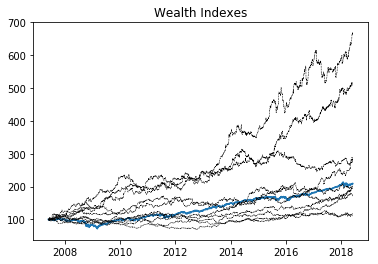

In [52]:
# 6.1.9
wi_all = pd.concat([port_actual,port_sim_a],axis=1)
sims=['sim'+str(i) for i in range(1,11)]
sims.append('actual')
sims.sort()
wi_all.columns = [sims]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(wi_all.actual)
ax.plot(wi_all.iloc[:,1:], color='k', linestyle='--', linewidth=0.5)
ax.set(title='Wealth Indexes')

In [53]:
# 6.2.1
import scipy.stats as st
random.seed(401)
ret = st.norm.rvs(loc=0.05, scale=0.10, size=100)

In [54]:
# 6.2.2
prices_a = np.cumprod(1+ret)

In [55]:
# 6.2.3
managers = pd.read_csv("managers.csv", index_col=0)
mean_ret = managers.iloc[:,7].mean()
print("Mean Return ", mean_ret)
sd_1 = managers.iloc[:,7].std()
print("Standard Deviation" , sd_1)

Mean Return  0.008665340909090907
Standard Deviation 0.04330924151327766


In [56]:
# 6.2.4
random.seed(49)
sp500_sim = st.norm.rvs(loc=mean_ret, scale=sd_1, size=100)
sp500_sim[0:5]

array([ 0.06793134, -0.02487256, -0.01397776,  0.00818299,  0.00161251])

In [57]:
# 6.2.5
sp500_sim_a = pd.Series(data=st.norm.rvs(loc=mean_ret, scale=sd_1, size=len(managers.iloc[:,7]),  random_state=49),index=managers.iloc[:,7].index)
sp500_sim_a.head()

Index
1996-01-31   -0.036513
1996-02-29   -0.026885
1996-03-31    0.037472
1996-04-30    0.087602
1996-05-31   -0.053769
dtype: float64

In [58]:
# 6.2.6
assets_sim = st.norm.rvs(loc=managers.iloc[:,7:10].mean(), scale=managers.iloc[:,7:10].std(), size=(len(managers.iloc[:,7:10]), len(managers.iloc[:,7:10].columns)),random_state=666)
assets_sim = pd.DataFrame(data=assets_sim, columns=managers.iloc[:,7:10].columns, index=managers.iloc[:,7:10].index)
assets_sim.head()

,SP500 TR,US 10Y TR,US 3m TR
Index,,,
1996-01-31,0.044360,0.014172,0.004978
1996-02-29,0.048036,-0.007272,0.003063
1996-03-31,0.009489,-0.014857,0.004183
1996-04-30,-0.025395,0.016800,0.001837
1996-05-31,0.051031,-0.010640,0.002781


In [59]:
# 6.2.7
print(managers.iloc[:,7:10].mean())
print(assets_sim.mean())

SP500 TR     0.008665
US 10Y TR    0.004385
US 3m TR     0.003226
dtype: float64
SP500 TR     0.007489
US 10Y TR    0.004452
US 3m TR     0.003243
dtype: float64


In [60]:
# 6.2.8
print(managers.iloc[:,7:10].std())
print(assets_sim.std())

SP500 TR     0.043309
US 10Y TR    0.020390
US 3m TR     0.001493
dtype: float64
SP500 TR     0.045566
US 10Y TR    0.020968
US 3m TR     0.001436
dtype: float64


In [61]:
# 6.3.1
tdist_ret = st.t(df=13).rvs(100000) * 0.01

In [62]:
# 6.3.2
managers = pd.read_csv("managers.csv", index_col=0)
spy_ret = managers.iloc[:,7]
spy_t_model = st.t.fit(spy_ret) 
spy_t_model

(13.127181198208856, 0.009951186302129066, 0.039741880228207016)

In [63]:
# 6.3.3
norm_ret = st.norm.rvs(size=100000, loc=0.05/252, scale=0.15/np.sqrt(252), random_state=77)

In [64]:
# 6.3.4
t_kurt = st.kurtosis(tdist_ret)
norm_kurt = st.kurtosis(norm_ret)
print(t_kurt)
print(norm_kurt)

0.6477285034045761
-0.021129211465741538


[Text(0.5,1,'Wealth Indexes')]

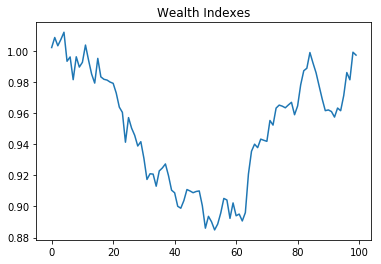

In [65]:
# 6.3.5
norm_ret = st.norm.rvs(size=100, loc=0.05/252, scale=0.15/np.sqrt(252), random_state=77)
prices_a = np.cumprod(1+norm_ret)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(prices_a)
ax.set(title='Wealth Indexes')

In [67]:
# 6.3.6
{x:managers.loc[:,x] for x in managers.iloc[:,7:10].columns}
fit = {ticker: st.t.fit(managers.loc[:,ticker]) for ticker in managers.iloc[:,7:10].columns}
mu = [item[1][1] for item in fit.items()]
sigma = [item[1][2] for item in fit.items()]
nu = [item[1][0] for item in fit.items()]
n = len(managers.iloc[:,7:10])
sim_dat = st.t.rvs(df=nu, loc=mu, scale=sigma, size=(n, 3), random_state=198)
sim_dat_ts = pd.DataFrame(data=sim_dat, index=managers.index, columns=managers.columns[7:10])

In [68]:
# 6.4.1
ret_1 = managers.iloc[:,[0,2,3,7]]
ret_1.columns = ['HF-A','HF-B','HF-C','SP500']
coefficients_1 = sm.OLS(ret_1.SP500,ret_1.iloc[:,:-1]).fit()
coefficients_1.params

HF-A    0.582937
HF-B    0.476156
HF-C    0.130002
dtype: float64

In [69]:
# 6.4.2
from sklearn.linear_model import LinearRegression
def coef(A):
    reg = LinearRegression(fit_intercept=True)
    X = A[:,:-1]
    y = A[:,-1]
    reg.fit(X, y)
    return {"coef": reg.coef_, "intercept": reg.intercept_}

In [72]:
# 6.4.3
from resample.bootstrap import bootstrap
results = bootstrap(a=ret_1, f=coef, b=10000, family='t')
param_frame = pd.DataFrame([pd.Series(x) for x in results])

[0.25115664 0.80918891]


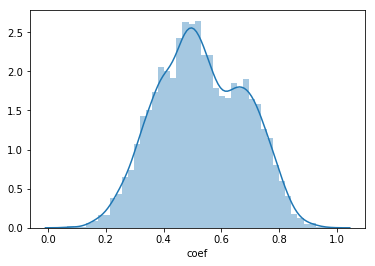

In [77]:
# 6.4.4
HFB_coef = param_frame["coef"].map(lambda x: x[1])
print(np.quantile(HFB_coef, q=[0.025, 0.975]))

# 6.4.5
# import seaborn as sns
sns.distplot(HFB_coef, hist=True)

# 7 - Modeling Tail Risk

In [78]:
# 7.1.1
alpha = np.array([0.05, 0.01])
conf_l= 1-alpha
VaR_1 = st.norm.ppf(q=alpha, loc=0.07, scale=0.15)
VaR_1

array([-0.17672804, -0.27895218])

In [79]:
# 7.1.2
VaR_1_alt = 0.07 + 0.15 * st.norm.ppf(q=alpha)
VaR_1_alt

array([-0.17672804, -0.27895218])

In [80]:
# 7.1.3
prob_1 = st.norm.cdf(-0.176728, loc=0.07, scale=0.15)
prob_1

0.05000003028250213

In [81]:
# 7.1.4
es_1 = 0.07 + 0.15 * st.norm.pdf(st.norm.ppf(q=alpha))/alpha
es_1

array([0.37940692, 0.46978213])

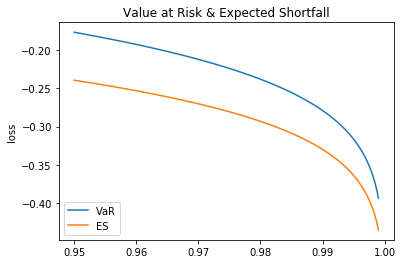

In [82]:
# 7.1.5
alpha = np.linspace(0.05, 0.001, num=1000)
conf_1 = 1 -alpha
VaR_a = 0.07 + 0.15 * st.norm.ppf(q=alpha)
ES_a = 0.07 + 0.15 * (st.norm.pdf(st.norm.ppf(q=alpha))/alpha) * -1
columns = ['VaR','ES']
data = [VaR_a, ES_a]
VaR_ES_a = pd.DataFrame(dict(zip(columns, data)))
VaR_ES_a.index = conf_1
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(VaR_ES_a)
ax.set(ylabel='loss', title='Value at Risk & Expected Shortfall')
ax.legend(VaR_ES_a.columns, loc='lower left')

In [83]:
# 7.1.6
managers = pd.read_csv("managers.csv", index_col=0)
sp500_ret = managers.iloc[:,7]
fit_norm = st.norm.fit(sp500_ret)
alpha = 0.05
mu = fit_norm[0]
sigma = fit_norm[1]
VaR_norm = mu + sigma * st.norm.ppf(q=alpha)
VaR_norm

-0.062301670575593604

In [84]:
# 7.1.7
managers = pd.read_csv("managers.csv", index_col=0)
sp500_ret = managers.iloc[:,7]
fit_t = st.t.fit(sp500_ret)
alpha = 0.05
nu = fit_t[0]
mu = fit_t[1]
sigma = fit_t[2]
VaR_t = sigma * st.t(df=nu).ppf(q=alpha)
VaR_t

-0.07032811587361633

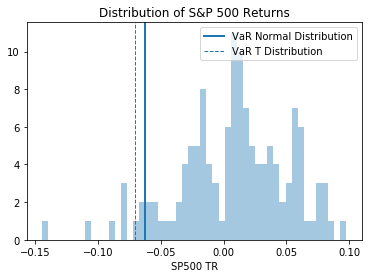

In [85]:
# 7.1.8
managers = pd.read_csv("managers.csv", index_col=0)
sp500_ret = managers.iloc[:,7]
g=sns.distplot(sp500_ret, bins=50, kde=False)
plt.title("Distribution of S&P 500 Returns")
plt.axvline(x=VaR_norm, lw=2)
plt.axvline(x=VaR_t,linestyle='--', lw=1)
plt.legend(["VaR Normal Distribution", "VaR T Distribution"])

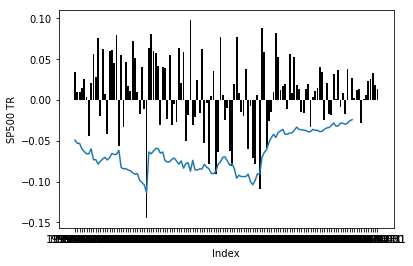

In [89]:
# 7.1.8
managers = pd.read_csv("managers.csv", index_col=0)
sp500_ret = managers.iloc[:,7]
def ES(data):
    fit_t = st.t.fit(data)
    alpha = 0.05
    nu = fit_t[0]
    mu = fit_t[1]
    sigma = fit_t[2]
    VaR_t = sigma * st.t(df=nu).ppf(q=alpha)
    return VaR_t

es_ttm = sp500_ret.rolling(window=12).apply(ES, raw=True)
sns.barplot(x=sp500_ret.index, y=sp500_ret, color='k')
sns.lineplot(x=es_ttm.index, y=es_ttm)

In [90]:
# 7.2.1
start_date='1991-12-31'
end_date='2018-12-01'
tickers = ['VFINX','VFITX']


start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)
prices = pd.DataFrame()

for ticker in tickers:
#     prices[ticker] = get_historical_data(ticker, start=start_date, end=end_date, output_format='pandas').loc[:,'close']
    prices[ticker] = client.get_dataframe(ticker, startDate=start_date, endDate=end_date).loc[:,'adjClose']
prices = prices.dropna()
returns = prices.pct_change()
returns = returns.dropna()


weights = pd.Series([0.6,0.4],index = returns.columns)
weighSpecifiedAlgo = bt.algos.WeighSpecified(**weights)
port_60_40 = bt.Strategy('Rebalance', [bt.algos.RunYearly(),
                       bt.algos.SelectAll(),
                       weighSpecifiedAlgo,
                       bt.algos.Rebalance()])
test = bt.Backtest(port_60_40, prices,progress_bar=True)
res = bt.run(test)
port_ret = res.prices.pct_change().dropna()

Rebalance
0% [############################# ] 100% | ETA: 00:00:00

C:\Users\Beau\Anaconda3\lib\site-packages\ffn\core.py:2054: RuntimeWarning: invalid value encountered in minimum
  negative_returns = np.minimum(returns, 0.)


[Text(0,0.5,'Denisty'), Text(0.5,1,'Distribution of 60/40 Returns')]

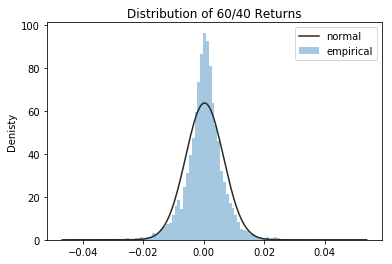

In [91]:
fig, ax = plt.subplots()
sns.distplot(port_ret, bins=100,kde=False, fit=st.norm, ax=ax)
ax.legend(labels=["normal","empirical"])
ax.set(ylabel="Denisty",title="Distribution of 60/40 Returns")

[Text(0,0.5,'F(x)'), Text(0.5,1,'CDF')]

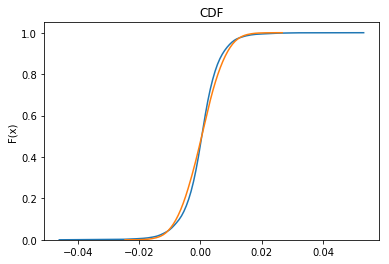

In [110]:
# 7.2.2
fit = st.norm.fit(port_ret)
norm_data = st.norm.rvs(size=10000, loc=fit[0], scale=fit[1])

fig, ax = plt.subplots()
g=sns.distplot(port_ret,hist=False,kde_kws=dict(cumulative=True), ax=ax)
h=sns.distplot(norm_data,hist=False,kde_kws=dict(cumulative=True), ax=ax)
ax.set(ylabel='F(x)',title='CDF')

(0, 0.1)

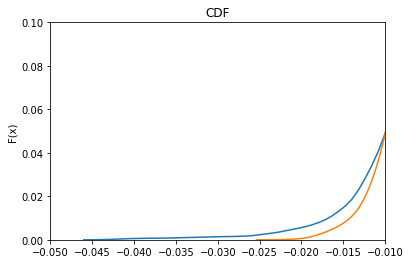

In [111]:
# 7.2.3
fit = st.norm.fit(port_ret)
norm_data = st.norm.rvs(size=10000, loc=fit[0], scale=fit[1])

fig, ax = plt.subplots()
g=sns.distplot(port_ret,hist=False,kde_kws=dict(cumulative=True), ax=ax)
h=sns.distplot(norm_data,hist=False,kde_kws=dict(cumulative=True), ax=ax)
ax.set(ylabel='F(x)',title='CDF')
ax.set_xlim(-0.05,-0.01)
ax.set_ylim(0,0.1)

C:\Users\Beau\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


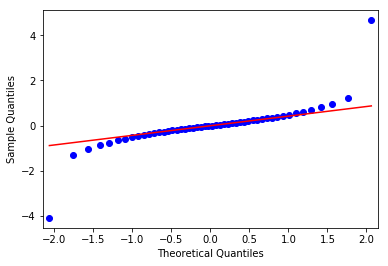

In [130]:
# 7.2.4
fig = sm.qqplot(np.quantile(port_ret, q=np.linspace(0,1)), fit=st.norm, line='q')
fig.show()

# 8 - Risk Contribution and Risk Parity

In [132]:
# 8.1.1

start_date='2007-12-31'
end_date='2017-12-31'
tickers = ['SPY','AGG','EFA','EEM','GSG']


start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)
prices = pd.DataFrame()

for ticker in tickers:
    prices[ticker] = client.get_dataframe(ticker, startDate=start_date, endDate=end_date).loc[:,'adjClose']
prices = prices.dropna()
returns = prices.pct_change()
returns = returns.dropna()

In [133]:
# 8.1.2
def calculate_portfolio_var(w,V):
    # function that calculates portfolio risk
    w = np.matrix(w)
    return (w*V*w.T)[0,0]

def calculate_risk_contribution(V,w=np.full((1,len(returns.columns)),fill_value=1/len(returns.columns))):
    # function that calculates asset contribution to total risk
    w = np.matrix(w)
    sigma = np.sqrt(calculate_portfolio_var(w,V))
    # Marginal Risk Contribution
    MRC = V*w.T
    # Risk Contribution
    RC = np.multiply(MRC,w.T)/sigma
    return RC
# calculate_risk_contribution(w=np.full((1,5),fill_value=0.2), V=returns.cov().values)
# calculate_portfolio_var(w=np.full((1,5),fill_value=0.2), V=returns.cov().values)

In [134]:
# 8.1.2
# set asset allocation weights
w = np.matrix(np.full((1,5),fill_value=0.2))
V = returns.cov().values
# portfolio volatility (variance)
port_var = w*V*w.T
sigma = np.sqrt(port_var)

# marginal contribution to risk
mcr = V*w.T

# component contribution to risk
cr = np.multiply(mcr,w.T)/sigma

# percent of contribution to overall portfolio risk
cr_port = cr / sigma
# combine cr and cr.port

cr_1 = pd.DataFrame(cr.reshape(1,5), columns=tickers, index=['contribution'])
cr_2 = pd.DataFrame( cr_port.reshape(1,5), columns=tickers, index=['% of contribution'])
cr_all = pd.concat([cr_1,cr_2])
cr_all

,SPY,AGG,EFA,EEM,GSG
contribution,0.002351,-0.000025,0.002928,0.003815,0.002147
% of contribution,0.209605,-0.002229,0.261080,0.340098,0.191446


In [135]:
# 8.1.3
def Risk_Contribution(V, w=np.full((1,len(returns.columns)),fill_value=1/len(returns.columns)),tickers=tickers):
    # portfolio volatility (variance)
    port_var = w*V*w.T
    sigma = np.sqrt(port_var)

    # marginal contribution to risk
    mcr = V*w.T

    # component contribution to risk
    cr = np.multiply(mcr,w.T)/sigma

    # percent of contribution to overall portfolio risk
    cr_port = cr / sigma

    # combine cr and cr.port
    cr = pd.DataFrame(data=cr.reshape(-1,5), index=['contribution'], columns=tickers)
    cr_port = pd.DataFrame(data=cr_port.reshape(-1,5), index=['percent of contribution'], columns=tickers)
    cr_all = pd.concat([cr,cr_port])
    return cr_all

Risk_Contribution(V=returns.cov().values, w=w)

,SPY,AGG,EFA,EEM,GSG
contribution,0.002351,-0.000025,0.002928,0.003815,0.002147
percent of contribution,0.209605,-0.002229,0.261080,0.340098,0.191446


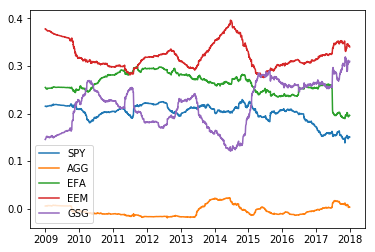

In [136]:
# 8.1.4
# rc_roll = pd.DataFrame(columns=tickers, index=returns.index[251:])
rc_roll = []
for i in range(251,len(returns)):
    ret = returns.iloc[i-251:i,:]
    V = ret.cov().values
    w = np.matrix(np.full((1,5),fill_value=0.2))
    rc_perc = Risk_Contribution(V=V,w=w, tickers=tickers).loc['percent of contribution',:]
    rc_roll.append(rc_perc)
rc_roll = pd.concat(rc_roll, axis=1).transpose()
rc_roll.index = returns.index[251:]
plt.plot(rc_roll)
plt.legend(labels=rc_roll.columns)

In [137]:
# 8.2.1
# 8.2.2
import ffn
ffn.calc_erc_weights(returns)

SPY    0.096786
AGG    0.667934
EFA    0.076194
EEM    0.060071
GSG    0.099016
Name: erc, dtype: float64

5 Percent Target
0% [############################# ] 100% | ETA: 00:00:0010 Percent Target


C:\Users\Beau\Anaconda3\lib\site-packages\ffn\core.py:2054: RuntimeWarning: invalid value encountered in minimum
  negative_returns = np.minimum(returns, 0.)


0% [############################# ] 100% | ETA: 00:00:00No Target
0% [############################# ] 100% | ETA: 00:00:00

C:\Users\Beau\Anaconda3\lib\site-packages\ffn\core.py:2056: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


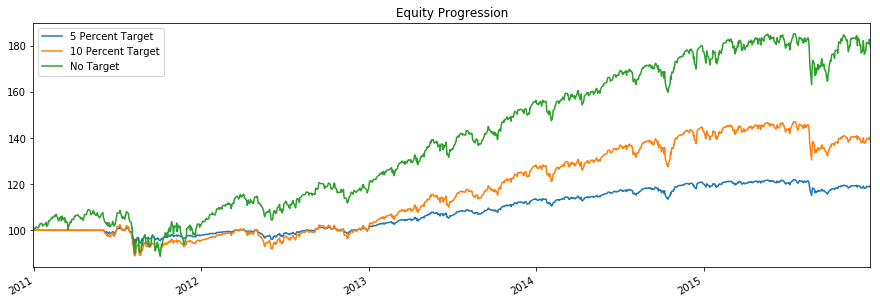

In [138]:
# 8.3.1

start_date='2010-12-31'
end_date='2015-12-31'
tickers = ['SPY']

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)
prices = pd.DataFrame()

for ticker in tickers:
    prices[ticker] = client.get_dataframe(ticker, startDate=start_date, endDate=end_date).loc[:,'adjClose']
prices = prices.dropna()
returns = prices.pct_change()
returns = returns.dropna()

def vol_target_w(prices, window=90, risk_factor=0.1):
    a = prices.pct_change()
    b = a.rolling(window=window).std() * np.sqrt(252)
    c = risk_factor/b
    f = pd.DataFrame(c, index=prices.index, columns=tickers)
    return f

w_5per = vol_target_w(prices, risk_factor=0.05)
w_10per = vol_target_w(prices, risk_factor=0.1)

s = bt.Strategy('5 Percent Target', [bt.algos.RunMonthly(),
                                     bt.algos.SelectAll(),
                                     bt.algos.WeighTarget(w_5per),
                                     bt.algos.Rebalance()])


s2 = bt.Strategy('10 Percent Target', [bt.algos.RunMonthly(),
                                       bt.algos.SelectAll(),
                                       bt.algos.WeighTarget(w_10per),
                                       bt.algos.Rebalance()])

s3 = bt.Strategy('No Target', [bt.algos.RunOnce(),
                                       bt.algos.SelectAll(),
                                       bt.algos.WeighEqually(),
                                       bt.algos.Rebalance()])
test1 = bt.Backtest(s, prices)
test2 = bt.Backtest(s2, prices)
test3 = bt.Backtest(s3, prices)
res = bt.run(test1, test2, test3)
res.plot()

In [139]:
# 8.3.2
res.stats.loc['yearly_vol',:]

5 Percent Target     0.0611012
10 Percent Target     0.128307
No Target             0.126819
Name: yearly_vol, dtype: object

# 9 - Style Analysis and Replicating Indexes

In [140]:
# 9.1.1
start_date='2010-12-31'
end_date='2017-12-31'
tickers = ['SPY','AGG','EFA','EEM','GSG','AOR']

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)
prices = pd.DataFrame()

for ticker in tickers:
    prices[ticker] = client.get_dataframe(ticker, startDate=start_date, endDate=end_date).loc[:,'adjClose']
prices = prices.dropna()
returns = prices.pct_change()
returns = returns.dropna()
returns = returns.resample('1M', closed='left').first()

from scipy import optimize
aor_style = optimize.nnls(returns.iloc[:,0:-1],returns.AOR)
weights = np.round(aor_style[0]/sum(aor_style[0]), 4)
pd.DataFrame(weights,index=tickers[:-1], columns=["Weight"])

,Weight
SPY,0.4342
AGG,0.4132
EFA,0.1287
EEM,0.0239
GSG,0.0000


In [141]:
def SharpeStyleAnalysis(factor, returns):
    from scipy.optimize import minimize
    N = returns.shape[1] -1    
    init_guess = np.array(N*[1. / N,])
    cons = ({'type': 'eq', 'fun': lambda b: np.sum(b) - 1.})
    bnds = tuple((0, 1) for b in range(N))
    D = np.array(returns.cov().loc[returns.cov().index != factor, returns.cov().columns != factor])
    d = np.array(returns.cov().loc[returns.cov().index != factor, returns.cov().columns == factor])
    fun = lambda b, d, D: np.dot(-d.T, b) + np.dot(1/2 * b.T, np.dot(D,b))
    res = minimize(fun, init_guess, args=(d,D), 
               method='SLSQP', 
               bounds=bnds, 
               constraints=cons, 
               tol=1e-10)
    output = pd.DataFrame(np.round(res.x,3), index = tickers[:-1], columns=["Weight"])
    return output
SharpeStyleAnalysis('AOR', returns)

,Weight
SPY,0.293
AGG,0.464
EFA,0.172
EEM,0.071
GSG,0.000


In [142]:
def SharpeStyleAnalysis(factor, returns):
    from scipy.optimize import minimize
    N = returns.shape[1] -1    
    init_guess = np.array(N*[1. / N,])
    a1 = np.repeat(1,N)
    a2 = np.identity(N)
    w_min = np.repeat(0,N+1)
    w_min[0] = 1
    b_0 = w_min
    Amat = np.vstack((a1,a2)).T
    cons = ({'type': 'eq', 'fun': lambda b: np.sum(b) - 1.})
    bnds = tuple((0, 1) for b in range(N))
    D = np.array(returns.cov().loc[returns.cov().index != factor, returns.cov().columns != factor])
    d = np.array(returns.cov().loc[returns.cov().index != factor, returns.cov().columns == factor])
    fun = lambda b, d, D: np.dot(-d.T, b) + np.dot(1/2 * b.T, np.dot(D,b))
    res = minimize(fun, init_guess, args=(d,D), 
               method='SLSQP', 
               bounds=bnds, 
               constraints=cons, 
               tol=1e-10)
    output = pd.DataFrame(np.round(res.x,3), index = tickers[:-1], columns=["Weight"])
    return output
SharpeStyleAnalysis('AOR', returns)

,Weight
SPY,0.293
AGG,0.464
EFA,0.172
EEM,0.071
GSG,0.000


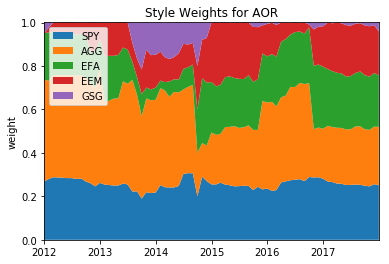

In [143]:
regression = np.zeros((len(returns.index)-11,5))
for row in range(11, len(returns.index)):
    ret = returns.iloc[row-11:row,:]
    aor_style = SharpeStyleAnalysis('AOR',ret)
    regression[row-11] = aor_style.Weight

style_roll_weights = pd.DataFrame(data=regression, index=returns.index[11:], columns=ret.columns[ret.columns != 'AOR'])

plt.stackplot(style_roll_weights.index, 
              style_roll_weights['SPY'], style_roll_weights['AGG'], style_roll_weights['EFA'],  style_roll_weights['EEM'],  style_roll_weights['GSG']
              , labels=['SPY','AGG','EFA','EEM','GSG'])
plt.legend(loc='upper left')
plt.margins(0,0)
plt.title('Style Weights for AOR')
plt.ylabel("weight")

plt.show()

In [144]:
# 9.1.2
import statsmodels.api as sm
regression_1 = sm.OLS(returns.AOR,returns.iloc[:,0:-1]).fit()
regression_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    AOR   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     321.9
Date:                Sat, 23 Feb 2019   Prob (F-statistic):           5.36e-51
Time:                        13:52:06   Log-Likelihood:                 443.17
No. Observations:                  84   AIC:                            -876.3
Df Residuals:                      79   BIC:                            -864.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
SPY            0.4319      0.040     10.841      0.000       0.353       0.511
AGG            0.4071      0.080      5.074      0.000       0.247       0.567
EFA            0.1303      0.028      4.652      0.000       0.075       0.186
EEM            0.0268      0.020      1.362      0.177      -0.012       0.066
GSG           -0.0065      0.010     -0.629      0.531      -0.027       0.014
==============================================================================
Omnibus:                        0.215   Durbin-Watson:                   1.801
Prob(Omnibus):                  0.898   Jarque-Bera (JB):                0.248
Skew:                          -0.115   Prob(JB):                        0.884
Kurtosis:                       2.866   Cond. No.                         12.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [145]:
# 9.2.1
regression = np.zeros((len(returns.index)-11,5))

for row in range(11, len(returns.index)):
    y = returns.AOR[row-11: row]
    x = returns.iloc[row-11:row,:-1]
    aor_style = optimize.nnls(x,y)
    weights = np.round(aor_style[0]/sum(aor_style[0]), 4)
    regression[row-11] = weights

style_roll_weights = pd.DataFrame(data=regression, index=returns.index[11:], columns=tickers[:-1])
style_roll_weights.head()


,SPY,AGG,EFA,EEM,GSG
date,,,,,
2011-12-31 00:00:00+00:00,0.7714,0.0000,0.2286,0.0,0.0
2012-01-31 00:00:00+00:00,0.7219,0.1607,0.1173,0.0,0.0
2012-02-29 00:00:00+00:00,0.6532,0.2333,0.1135,0.0,0.0
2012-03-31 00:00:00+00:00,0.4324,0.4601,0.1075,0.0,0.0
2012-04-30 00:00:00+00:00,0.3536,0.5404,0.1060,0.0,0.0


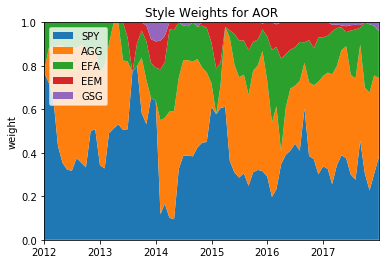

In [146]:
# 9.2.2
plt.stackplot(style_roll_weights.index, 
              style_roll_weights['SPY'], style_roll_weights['AGG'], style_roll_weights['EFA'],  style_roll_weights['EEM'],  style_roll_weights['GSG']
              , labels=['SPY','AGG','EFA','EEM','GSG'])
plt.legend(loc='upper left')
plt.margins(0,0)
plt.title('Style Weights for AOR')
plt.ylabel("weight")

plt.show()

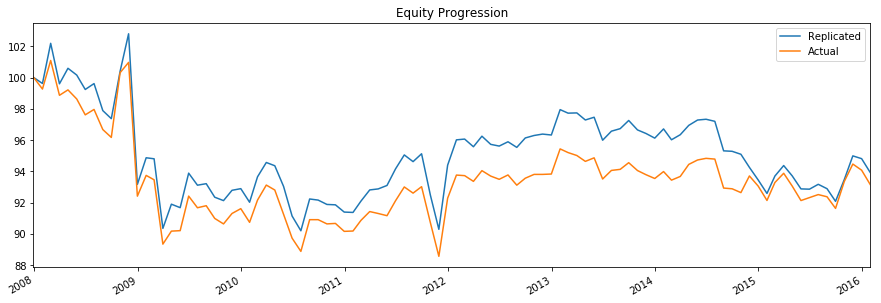

In [147]:
# 9.3.1
from scipy import optimize

start_date='2006-12-31'
end_date='2015-12-31'
tickers = ["XLF", 
            "XLK", 
            "XLI", 
            "XLB", 
            "XLY", 
            "XLV", 
            "XLU", 
            "XLP", 
            "XLE", 
            "VOX", 
            "VNQ", 
            "SPY"]

start_date = pd.to_datetime(start_date)
end_date = pd.to_datetime(end_date)
prices = pd.DataFrame()

for ticker in tickers:
    prices[ticker] = client.get_dataframe(ticker, startDate=start_date, endDate=end_date).loc[:,'adjClose']
prices = prices.dropna()
returns = prices.pct_change()
returns = returns.dropna()
returns = returns.resample('1M', closed='left').first()

# generate style weights
regression = np.zeros((len(returns.index)-11,11))

for row in range(11, len(returns.index)):
    y = returns.SPY[row-11: row]
    x = returns.iloc[row-11:row,:-1]
    aor_style = optimize.nnls(x,y)
    weights = np.round(aor_style[0]/sum(aor_style[0]), 4)
    regression[row-11] = weights

style_roll_weights_sp = pd.DataFrame(data=regression, index=returns.index[11:], columns=tickers[:-1])
# transform weights to end of quarter frequency
weights_1 = style_roll_weights_sp.resample('BQ',closed='right').first()

# create replicated SPY index with
# quarterly rebalancing.
weights = weights_1
weighSpecifiedAlgo = bt.algos.WeighSpecified(**weights)
s1 = bt.Strategy('Replicated', [bt.algos.RunMonthly(),
                       bt.algos.SelectAll(),
                        bt.algos.WeighTarget(weights),
                       bt.algos.Rebalance()])
s2 = bt.Strategy('Actual', [bt.algos.RunOnce(),
                                       bt.algos.SelectAll(),
                                       bt.algos.WeighEqually(),
                                       bt.algos.Rebalance()])
prices = np.cumprod(np.exp(returns.iloc[11:,:]))
test1 = bt.Backtest(s1, prices.iloc[:,:-1],progress_bar=False)
test2 = bt.Backtest(s2, prices.iloc[:,-1:],progress_bar=False)
res = bt.run(test1,test2)
res.plot()

In [148]:
# 9.3.2
np.corrcoef(res.prices.Actual,res.prices.Replicated)

array([[1.        , 0.95831125],
       [0.95831125, 1.        ]])

# 10 - Estimating Shocks on Asset Prices

In [149]:
# 10.1.1
import pandas_datareader as pdr
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

fred = pdr.get_data_fred(['MCOILWTICO','RU1000TR'],start = "1986-01-01")
fred.fillna(method='ffill')
oil_r1000 = fred.resample('1M', closed='left').first()
oil_r1000.columns = ['oil','stocks']
oil_r1000_ret =oil_r1000.pct_change().dropna()
model = VAR(oil_r1000_ret)
var_lag = model.select_order(maxlags=12).aic
var_model = VAR(oil_r1000_ret*100)
results = var_model.fit(maxlags=12, ic='aic')

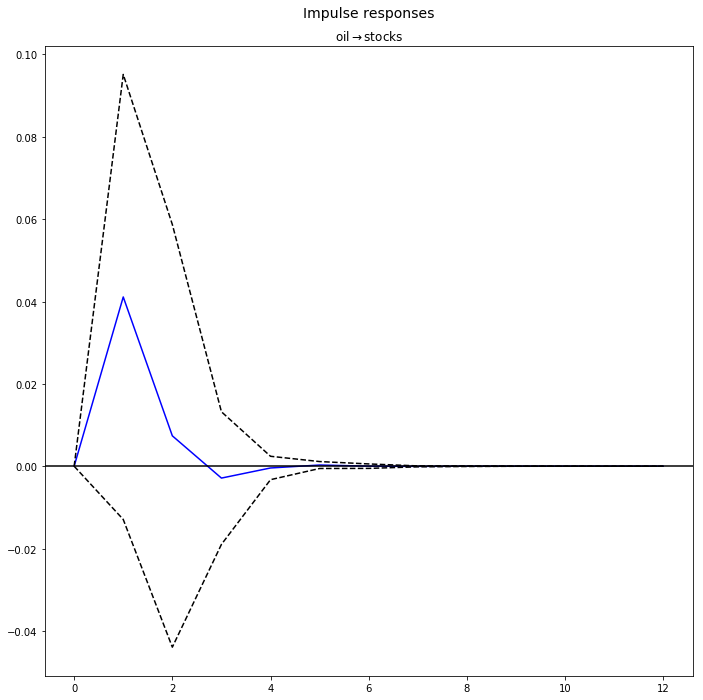

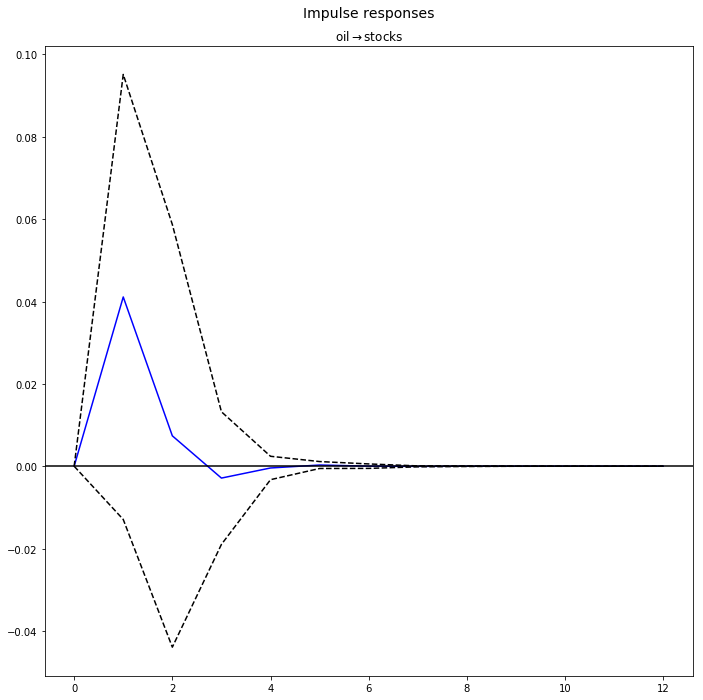

In [150]:
# 10.1.2
irf = results.irf(periods=12)
irf.plot(impulse='oil',response='stocks',orth=False)

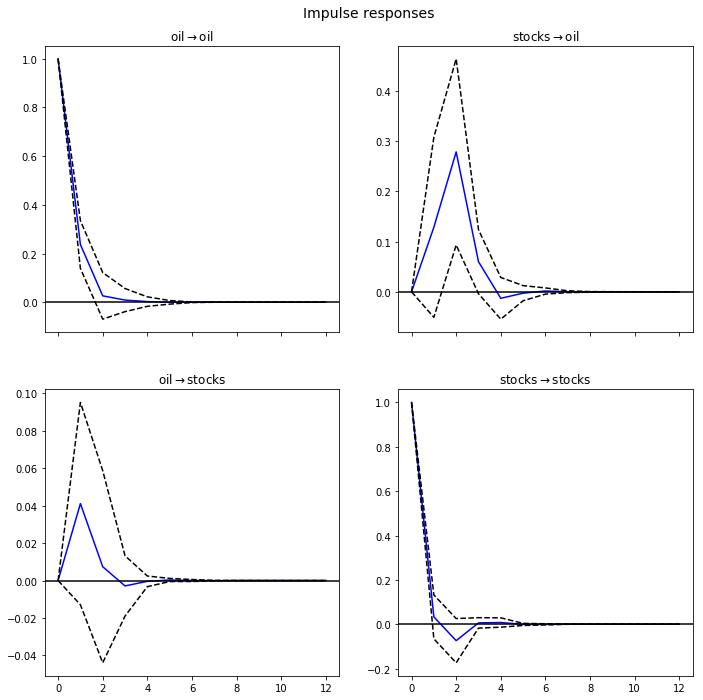

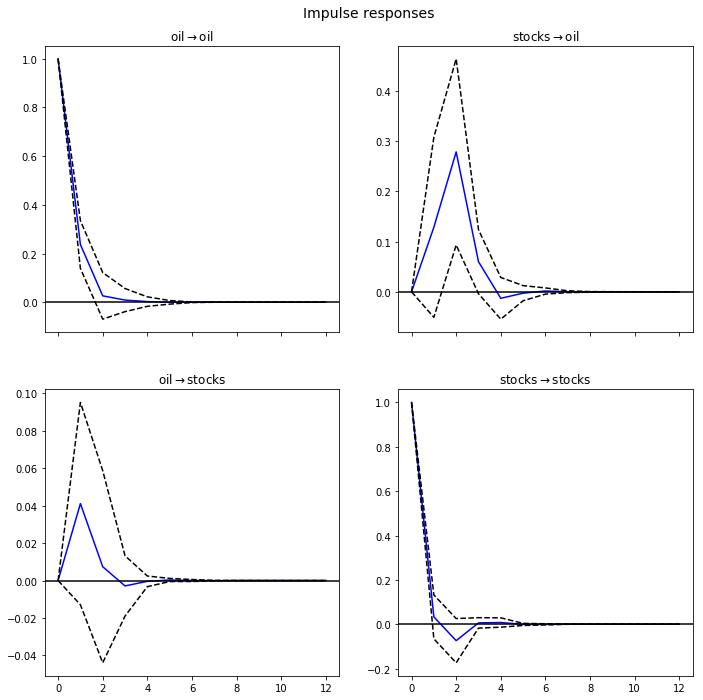

In [151]:
irf.plot()

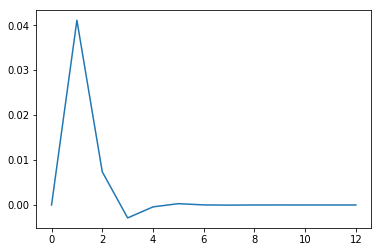

In [152]:
# 10.1.3
irf_data = plt.plot(irf.irfs[:,1,0])
